In [ ]:
# pip install qiskit

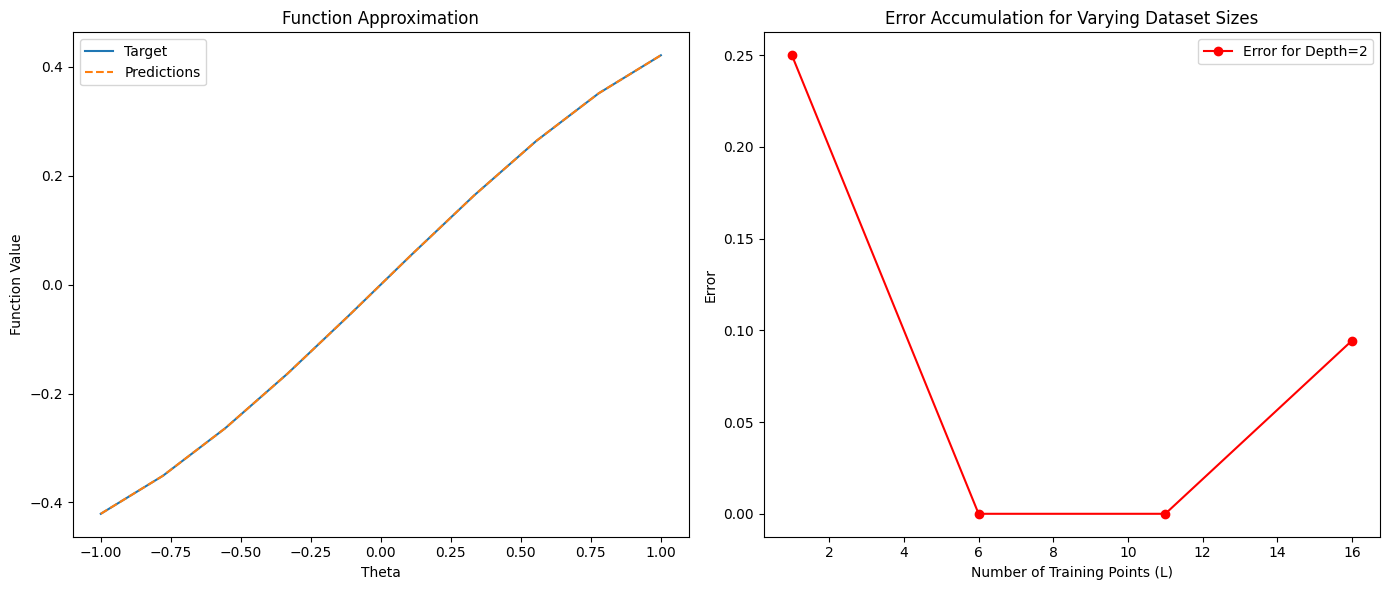

In [8]:
# -------------------------------------------------------- ENTANGLING LAYER --------------------------------------------------------------------
# this code is the 5-qubit entangling layer on 5 2-qubit gates
# from the paper: https://www.nature.com/articles/s41586-019-1666-5

# for the optimizer: Yulong derived the Jacobian differential forms to make his optimizer better. But for us we don't have this
# Yulong's paper calculated a differential and we need to implement this
# 
# we are doing this on signed sum using iter_tools package on Python to find the number of combinations for 5 qubits of [+1, -1]: +1+1-1-1-1
# This becomes a classification task where +1 is positive and -1 is negative: this is a signed sum
# if this is a classification task for horse or dog, you will need more iterations of the entanglement qubits

import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator

# -------------------- Config --------------------
CIRCUIT_DEPTH = 2
max_qubits = 5
reps = CIRCUIT_DEPTH
param_count = 2 * reps * max_qubits + 1  # For block + final rz
middle = 2  # entanglement
# m = 2.0  # linear
m = 0.5  # cosine/sine

# -------------------- Circuit --------------------
def block(circuit, parameters, reps):
    # QSP
    for i in range(circuit.num_qubits):
        for r in range(reps):
            circuit.rx(parameters[reps * (2 * i + r)], i)
            circuit.rz(parameters[reps * (2 * i + r) + 1], i)

def entangle(circuit, middle):
    # Entangle middle qubit: (2,1), (2,3), (2,0), (2,4)
    for i in range(1, 3):
        if 0 <= middle - i < circuit.num_qubits:
            circuit.cx(middle - i, middle)
        if 0 <= middle + i < circuit.num_qubits:
            circuit.cx(middle + i, middle)

def create_circuit(params, theta):
    # Function to create a single-qubit variational circuit
    circuit = QuantumCircuit(max_qubits)
    block(circuit, params, CIRCUIT_DEPTH)
    entangle(circuit, middle)
    for q in range(max_qubits):
        circuit.rz(params[-1], q)
    return circuit

# -------------------- Evaluate --------------------
def expectation_value(params, x):
    # Function to compute the expectation value <0|U|0> --> |00000>U<00000|
    circuit = create_circuit(params, x)
    state = Statevector.from_instruction(circuit)
    
    # Projector onto the |00000⟩ state
    projector = np.zeros((2**5, 2**5))
    projector[0,0] = 1 # |00000><00000|
    
    # Compute the expectation value
    expectation = state.expectation_value(Operator(projector))
    return np.real(expectation)

def cost(params, alphas, x_values, y_values):
    # Cost function incorporating alphas and phase parameters
    error = 0
    for x, y_true, alpha in zip(x_values, y_values, alphas):
        exp_val = expectation_value(params, x)
        y_pred = alpha * exp_val  # Each alpha corresponds to a specific theta (x)
        error += (y_true - y_pred) ** 2
    return error / len(x_values)


# -------------------- Training --------------------
def run_training(x_train, y_train, param_count):
    init_params = np.random.uniform(0, 2 * np.pi, param_count)
    init_alphas = np.random.uniform(0, 1, len(x_train))
    init_all = np.concatenate((init_params, init_alphas))

    def train(p):
        params = p[:param_count]
        alphas = p[param_count:]
        return cost(params, alphas, x_train, y_train)

    result = minimize(train, init_all, method='L-BFGS-B')
    params = result.x[:param_count]
    alphas = result.x[param_count:]
    return params, alphas

# -------------------- Function Approx Plot --------------------
x_pred = np.linspace(-1, 1, 10)
# y_pred = m * x_pred
# y_pred = m * np.cos(x_pred)
y_pred = m * np.sin(x_pred)
params, alphas = run_training(x_pred, y_pred, param_count)
predictions = [a * expectation_value(params, x) for x, a in zip(x_pred, alphas)]

# -------------------- Error Plot ------------------------------
errors = []
L_values = np.arange(1, 20, 5)
for L in L_values:
    x_train = np.linspace(-1, 1, L)
    y_train = m * x_train
    params_L, alphas_L = run_training(x_train, y_train, param_count)
    err = cost(params_L, alphas_L, x_train, y_train)
    errors.append(err)

# -------------------- Plots -----------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot approximation
ax1.plot(x_pred, y_pred, label="Target")
ax1.plot(x_pred, predictions, label="Predictions", linestyle='dashed')
ax1.set_title("Function Approximation")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Function Value")
ax1.legend()

# Plot error accumulation
ax2.plot(L_values, errors, marker='o', linestyle='-', color='red', label=f"Error for Depth={CIRCUIT_DEPTH}")
ax2.set_title("Error Accumulation for Varying Dataset Sizes")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Error")
ax2.legend()

plt.tight_layout()
plt.show()

Optimal parameters: [5.85842735 0.71456105 1.78861406 3.476024   3.3669315  2.80505155
 4.9454883  0.21515974 1.88715302 1.51660609 2.98134067 5.3929988
 1.56382665 3.06256475 1.63037084 1.13466234 0.54552766 5.35216507
 4.21049713 3.41530764 3.58861071]
Optimal alphas: [ 1.79794161 -1.25467787 -1.42726821  0.63742499  0.10687774  0.1068801
  0.63738685 -1.42722548 -1.25475291  1.79759569]
Predictions: [np.float64(0.16699157773975937), np.float64(-0.11834169362352089), np.float64(-0.1506503094452264), np.float64(0.2816958967873382), np.float64(0.09801184897542778), np.float64(0.09801401755647728), np.float64(0.2816790444359586), np.float64(-0.1506457996959085), np.float64(-0.11834877148393319), np.float64(0.16695944873792182)]
Target values: [ 0.16702466 -0.11833057 -0.15063411  0.28172071  0.09804337  0.09804337
  0.28172071 -0.15063411 -0.11833057  0.16702466]


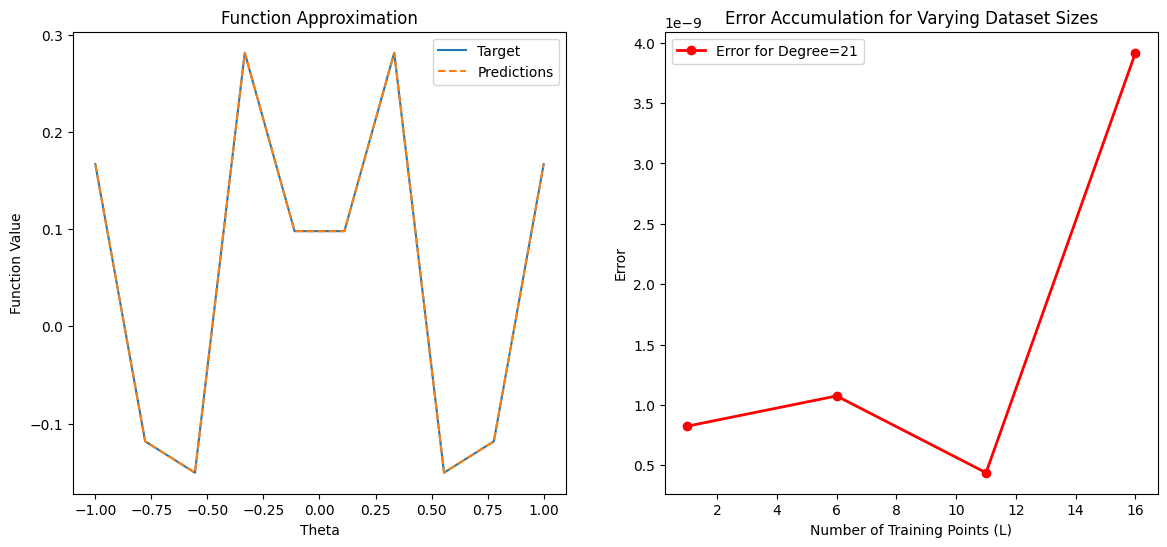

In [2]:
# -------------------------------------------------------- BESSEL FUNCTION --------------------------------------------------------------------
# for the optimizer: Yulong derived the Jacobian differential forms to make his optimizer better. But for us we don't have this
# Yulong's paper calculated a differential and we need to implement this
#
import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator
from scipy.special import j0




# Function to create a single-qubit variational circuit
def create_circuit(params, theta):
    circuit = QuantumCircuit(1)
    for i in range(20):
        circuit.rz(params[i], 0)
        circuit.rx(theta, 0)
    circuit.rz(params[20], 0)
    return circuit

# Function to compute the expectation value <0|U|0>
def expectation_value(params, x):
    circuit = create_circuit(params, x)
    state = Statevector.from_instruction(circuit)

    # Projector onto the |0⟩ state
    projector = Operator(np.array([[1, 0], [0, 0]]))

    # Compute the expectation value
    expectation = state.expectation_value(projector)
    return np.real(expectation)

# Cost function incorporating alphas and phase parameters
def cost(params, alphas, x_values, y_values):
    error = 0
    for x, y_true, alpha in zip(x_values, y_values, alphas):
        exp_val = expectation_value(params, x)
        y_pred = alpha * exp_val  # Each alpha corresponds to a specific theta (x)
        error += (y_true - y_pred) ** 2
    return error / len(x_values)

# Training data (x, y) for y = mx
x_train = np.linspace(-1, 1, 10)
#m = 2.0
#y_train = m * x_train

# Training data (x, y) for y = mcosx
# x_train = np.linspace(-1, 1, 10)
# m = 0.5
# y_train = m * np.sin(x_train)

# BESSEL FUNCTION Generate training data
x_train = np.linspace(-1, 1, 10)
y_train = j0(20 * x_train)

# Initialize random parameters, alphas, and phases
init_params = np.random.uniform(0, 2 * np.pi, 21)
init_alphas = np.random.uniform(0, 1, len(x_train))

# Training function
def train(params_and_alphas_phases):
    params = params_and_alphas_phases[:21]
    alphas = params_and_alphas_phases[21:21+len(x_train)]
    return cost(params, alphas, x_train, y_train)

# Optimize the parameters, alphas, and phases
init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

# Extract the optimal parameters, alphas, and phases
optimal_params = result.x[:21]
optimal_alphas = result.x[21:21+len(x_train)]

# Test the trained circuit
predictions = [alpha * expectation_value(optimal_params, x) for x, alpha in zip(x_train, optimal_alphas)]

# Print results
print("Optimal parameters:", optimal_params)
print("Optimal alphas:", optimal_alphas)
print("Predictions:", predictions)
print("Target values:", y_train)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x_train, y_train, label="Target")
ax1.plot(x_train, predictions, label="Predictions", linestyle='dashed')
ax1.legend()
ax1.set_title("Function Approximation")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Function Value")


# Store errors for different dataset sizes
errors = []
L_values = np.arange(1, 20, 5)  # Example: Varying the number of training points from 5 to 20

for L in L_values:
    # Generate training data for this value of L
    # x_train = np.linspace(-1, 1, L)
    # y_train = m * np.sin(x_train)  # Modify if using cos function
    # y_train = m * np.cos(x_train)

    # BESSEL FUNCTION Generate training data
    x_train = np.linspace(-1, 1, 10)
    y_train = j0(20 * x_train)

    # Initialize random parameters and alphas
    init_params = np.random.uniform(0, 2 * np.pi, 21)
    init_alphas = np.random.uniform(0, 1, len(x_train))

    # Define the train function again
    def train(params_and_alphas_phases):
        params = params_and_alphas_phases[:21]
        alphas = params_and_alphas_phases[21:21+len(x_train)]
        return cost(params, alphas, x_train, y_train)

    # Optimize
    init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
    result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

    # Extract the optimized parameters
    optimal_params = result.x[:21]
    optimal_alphas = result.x[21:21+len(x_train)]

    # Compute the final error
    error = cost(optimal_params, optimal_alphas, x_train, y_train)
    errors.append(error)

# Plot error accumulation
ax2.plot(L_values, errors, marker='o', linestyle='-', color='red', linewidth=2, label=f"Error for Degree={len(optimal_params)}")
ax2.set_title("Error Accumulation for Varying Dataset Sizes")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Error")
ax2.legend()
plt.show()

In [ ]:
# -------------------------------------------------------- BESSEL FUNCTION --------------------------------------------------------------------
# for the optimizer: Yulong derived the Jacobian differential forms to make his optimizer better. But for us we don't have this
# Yulong's paper calculated a differential and we need to implement this
#
import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator
from scipy.special import j0




# Function to create a single-qubit variational circuit
def create_circuit(params, theta):
    circuit = QuantumCircuit(1)
    for i in range(20):
        circuit.rz(params[i], 0)
        circuit.rx(theta, 0)
    circuit.rz(params[20], 0)
    return circuit

# Function to compute the expectation value <0|U|0>
def expectation_value(params, x):
    circuit = create_circuit(params, x)
    state = Statevector.from_instruction(circuit)

    # Projector onto the |0⟩ state
    projector = Operator(np.array([[1, 0], [0, 0]]))

    # Compute the expectation value
    expectation = state.expectation_value(projector)
    return np.real(expectation)

# Cost function incorporating alphas and phase parameters
def cost(params, alphas, x_values, y_values):
    error = 0
    for x, y_true, alpha in zip(x_values, y_values, alphas):
        exp_val = expectation_value(params, x)
        y_pred = alpha * exp_val  # Each alpha corresponds to a specific theta (x)
        error += (y_true - y_pred) ** 2
    return error / len(x_values)

# Training data (x, y) for y = mx
# x_train = np.linspace(-1, 1, 10)
#m = 2.0
#y_train = m * x_train

# Training data (x, y) for y = mcosx
# x_train = np.linspace(-1, 1, 10)
# m = 0.5
# y_train = m * np.sin(x_train)

# BESSEL FUNCTION Generate training data
x_train = np.linspace(-1, 1, 200)
y_train = j0(20 * x_train)

# Initialize random parameters, alphas, and phases
init_params = np.random.uniform(0, 2 * np.pi, 21)
init_alphas = np.random.uniform(0, 1, len(x_train))

# Training function
def train(params_and_alphas_phases):
    params = params_and_alphas_phases[:21]
    alphas = params_and_alphas_phases[21:21+len(x_train)]
    return cost(params, alphas, x_train, y_train)

# Optimize the parameters, alphas, and phases
init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

# Extract the optimal parameters, alphas, and phases
optimal_params = result.x[:21]
optimal_alphas = result.x[21:21+len(x_train)]

# Test the trained circuit
predictions = [alpha * expectation_value(optimal_params, x) for x, alpha in zip(x_train, optimal_alphas)]

# Print results
print("Optimal parameters:", optimal_params)
print("Optimal alphas:", optimal_alphas)
print("Predictions:", predictions)
print("Target values:", y_train)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x_train, y_train, label="Target")
ax1.plot(x_train, predictions, label="Predictions", linestyle='dashed')
ax1.legend()
ax1.set_title("Function Approximation")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Function Value")


# Store errors for different dataset sizes
errors = []
L_values = np.arange(1, 20, 5)  # Example: Varying the number of training points from 5 to 20

for L in L_values:
    # Generate training data for this value of L
    # x_train = np.linspace(-1, 1, L)
    # y_train = m * np.sin(x_train)  # Modify if using cos function
    # y_train = m * np.cos(x_train)

    # BESSEL FUNCTION Generate training data
    x_train = np.linspace(-1, 1, 200)
    y_train = j0(20 * x_train)

    # Initialize random parameters and alphas
    init_params = np.random.uniform(0, 2 * np.pi, 21)
    init_alphas = np.random.uniform(0, 1, len(x_train))

    # Define the train function again
    def train(params_and_alphas_phases):
        params = params_and_alphas_phases[:21]
        alphas = params_and_alphas_phases[21:21+len(x_train)]
        return cost(params, alphas, x_train, y_train)

    # Optimize
    init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
    result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

    # Extract the optimized parameters
    optimal_params = result.x[:21]
    optimal_alphas = result.x[21:21+len(x_train)]

    # Compute the final error
    error = cost(optimal_params, optimal_alphas, x_train, y_train)
    errors.append(error)

# Plot error accumulation
ax2.plot(L_values, errors, marker='o', linestyle='-', color='red', linewidth=2, label=f"Error for Degree={len(optimal_params)}")
ax2.set_title("Error Accumulation for Varying Dataset Sizes")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Error")
ax2.legend()
plt.show()

KeyboardInterrupt: 

: 

Optimal parameters: [0.53215052 4.54725118 2.07779459 3.30052938 5.99279472 5.448605
 2.22500152 0.96538963 4.95973456 4.22871708 4.79919566 4.06282658
 5.74535193 5.45320831 0.20633366 5.89169161 6.18390932 4.3118478
 5.53624471 2.36858173 2.33196191]
Optimal alphas: [-0.5906547  -0.42323422 -0.33419874 -0.24637687 -0.06004931  0.06006045
  0.24636402  0.33428501  0.42325391  0.59066745]
Predictions: [-0.4207510626600986, -0.3508662571950986, -0.2636993740273178, -0.16359229343881307, -0.05543635876605857, 0.055446638967346515, 0.1635837616057884, 0.26376744554677056, 0.35088258391936195, 0.4207601470027173]
Target values: [-0.42073549 -0.35084894 -0.26370769 -0.16359735 -0.05544131  0.05544131
  0.16359735  0.26370769  0.35084894  0.42073549]


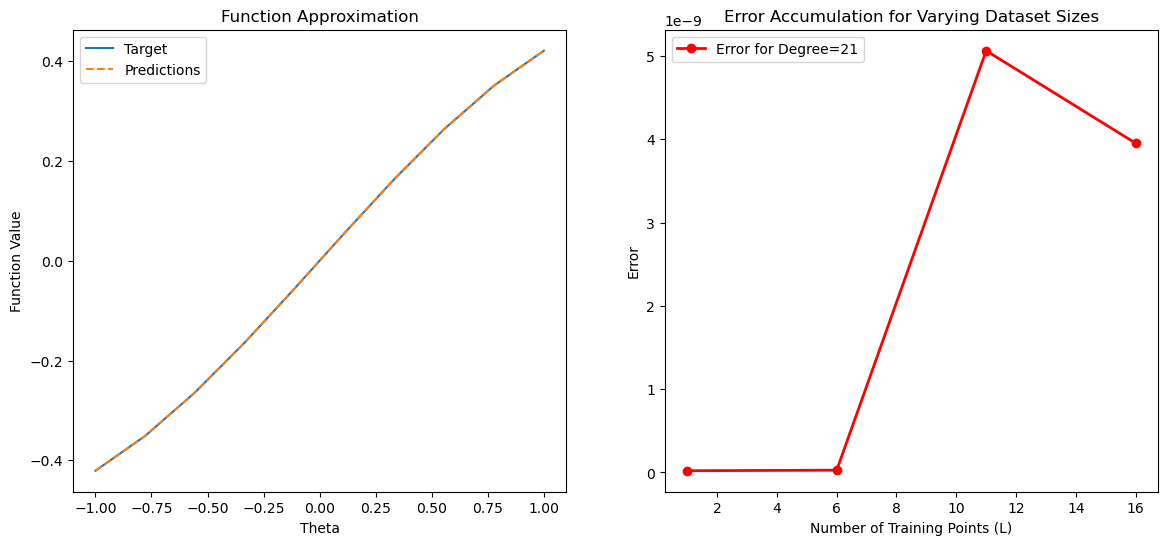

In [ ]:
# for the optimizer: Yulong derived the Jacobian differential forms to make his optimizer better. But for us we don't have this
# Yulong's paper calculated a differential and we need to implement this
#
import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator


# Function to create a single-qubit variational circuit
def create_circuit(params, theta):
    circuit = QuantumCircuit(1)
    for i in range(20):
        circuit.rz(params[i], 0)
        circuit.rx(theta, 0)
    circuit.rz(params[20], 0)
    return circuit

# Function to compute the expectation value <0|U|0>
def expectation_value(params, x):
    circuit = create_circuit(params, x)
    state = Statevector.from_instruction(circuit)

    # Projector onto the |0⟩ state
    projector = Operator(np.array([[1, 0], [0, 0]]))

    # Compute the expectation value
    expectation = state.expectation_value(projector)
    return np.real(expectation)

# Cost function incorporating alphas and phase parameters
def cost(params, alphas, x_values, y_values):
    error = 0
    for x, y_true, alpha in zip(x_values, y_values, alphas):
        exp_val = expectation_value(params, x)
        y_pred = alpha * exp_val  # Each alpha corresponds to a specific theta (x)
        error += (y_true - y_pred) ** 2
    return error / len(x_values)

# Training data (x, y) for y = mx
x_train = np.linspace(-1, 1, 10)
#m = 2.0
#y_train = m * x_train

# Training data (x, y) for y = mcosx
# x_train = np.linspace(-1, 1, 10)
m = 0.5
y_train = m * np.sin(x_train)

# Initialize random parameters, alphas, and phases
init_params = np.random.uniform(0, 2 * np.pi, 21)
init_alphas = np.random.uniform(0, 1, len(x_train))

# Training function
def train(params_and_alphas_phases):
    params = params_and_alphas_phases[:21]
    alphas = params_and_alphas_phases[21:21+len(x_train)]
    return cost(params, alphas, x_train, y_train)

# Optimize the parameters, alphas, and phases
init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

# Extract the optimal parameters, alphas, and phases
optimal_params = result.x[:21]
optimal_alphas = result.x[21:21+len(x_train)]

# Test the trained circuit
predictions = [alpha * expectation_value(optimal_params, x) for x, alpha in zip(x_train, optimal_alphas)]

# Print results
print("Optimal parameters:", optimal_params)
print("Optimal alphas:", optimal_alphas)
print("Predictions:", predictions)
print("Target values:", y_train)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x_train, y_train, label="Target")
ax1.plot(x_train, predictions, label="Predictions", linestyle='dashed')
ax1.legend()
ax1.set_title("Function Approximation")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Function Value")


# Store errors for different dataset sizes
errors = []
L_values = np.arange(1, 20, 5)  # Example: Varying the number of training points from 5 to 20

for L in L_values:
    # Generate training data for this value of L
    x_train = np.linspace(-1, 1, L)
    y_train = m * np.sin(x_train)  # Modify if using cos function
    # y_train = m * np.cos(x_train)

    # Initialize random parameters and alphas
    init_params = np.random.uniform(0, 2 * np.pi, 21)
    init_alphas = np.random.uniform(0, 1, len(x_train))

    # Define the train function again
    def train(params_and_alphas_phases):
        params = params_and_alphas_phases[:21]
        alphas = params_and_alphas_phases[21:21+len(x_train)]
        return cost(params, alphas, x_train, y_train)

    # Optimize
    init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
    result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

    # Extract the optimized parameters
    optimal_params = result.x[:21]
    optimal_alphas = result.x[21:21+len(x_train)]

    # Compute the final error
    error = cost(optimal_params, optimal_alphas, x_train, y_train)
    errors.append(error)

# Plot error accumulation
ax2.plot(L_values, errors, marker='o', linestyle='-', color='red', linewidth=2, label=f"Error for Degree={len(optimal_params)}")
ax2.set_title("Error Accumulation for Varying Dataset Sizes")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Error")
ax2.legend()
plt.show()